In [35]:
import os
from typing import Iterable
import pandas as pd
import pickle

class DatasetProvider:
    def __init__(self, path=None, file_formats: Iterable[str]=['csv']):
        self.cwd = os.getcwd() if path == None else path
        print(self.cwd)
        self.file_list = []
        for dirname, _, filenames in os.walk(self.cwd):
            for filename in filenames:
                if filename.split('.')[-1] in file_formats:
                    self.file_list.append(os.path.join(dirname, filename))
        return None

    def get_dataset(self, path: str=None):
        if path == None:
            self._frames = {}
            for file in self.file_list:
                _ds_name = file.split('/')[-1]
                self._frames[_ds_name] = pd.read_csv(file)
        else:
            self._frames = pd.read_csv(path)
        return self._frames

In [36]:
provider = DatasetProvider(path='../plot_data/unetx-bince/')

frames = provider.get_dataset()

../plot_data/unetx-bince/


In [37]:
mask = ('run_id', 'dataset', 'time_step_type', 'metric_name')

In [38]:
def process_tokens(string):
    tokens = {}
    run_id, substr = string.split('__metrics_')
    tokens['id'] = run_id
    tokens['dataset'], tokens['time_step_type'], *rest = substr.split('_')
    tokens['metric_type'] = '_'.join(rest).split('.')[0]
    return tokens

In [39]:
import pandas as pd

def summarize(frames):
    updated_frame_list = []
    for name, frame in frames.items():
        tokens = process_tokens(name)
        frame = frame.iloc[:, [0, 2]]
        frame = frame.rename({
            k: v for k, v in zip(frame.columns, ['epoch', 'loss'])
        }, axis=1)
        for token, val in tokens.items():
            frame.loc[:,token] = val
        updated_frame_list.append(frame)

    return pd.concat(updated_frame_list, axis=0)

df = summarize(frames)

# maxx = df[df.id == 'UNET-17'].epoch.max()
# df.loc[df.id == 'UNET-18', 'epoch'] = df.loc[df.id == 'UNET-18', 'epoch'] + maxx + 1

df = df.drop(['id', 'time_step_type'], axis=1).reset_index()
df

,index,epoch,loss,dataset,metric_type
0,0,1.0,0.004037,train,IoU_class_2
1,1,2.0,0.002533,train,IoU_class_2
2,2,3.0,0.003201,train,IoU_class_2
3,3,4.0,0.002630,train,IoU_class_2
4,4,5.0,0.002154,train,IoU_class_2
...,...,...,...,...,...
1165,190,191.0,0.304458,test,IoU_class_2
1166,191,192.0,0.313410,test,IoU_class_2
1167,192,193.0,0.307588,test,IoU_class_2
1168,193,194.0,0.318682,test,IoU_class_2


Text(0.5, 1.0, 'Test metrics')

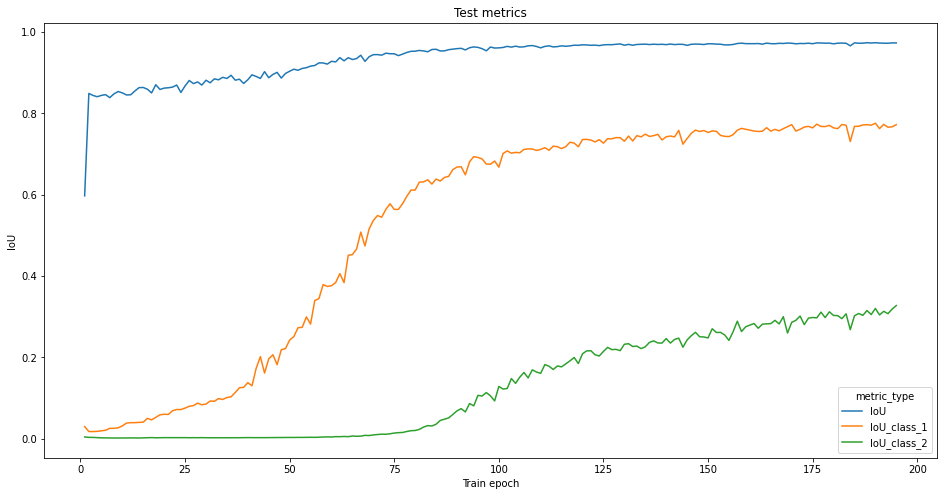

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(16, 8)) 

ax.set_ylabel("IoU")
ax.set_xlabel("Train epoch")

(
    sns.lineplot(data=df[df.dataset == 'test'], x='epoch', y='loss', hue='metric_type', ax=ax)
        .set_title('Test metrics')
        
)